In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.models import Model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa

import random

import pandas as pd
import Utils
import AG_RN
import importlib
importlib.reload(Utils)
importlib.reload(AG_RN)
from Utils import DataGenerator
from Utils import TimingCallback

# Test the accuracy of the NN

In [2]:
# Generamos una lista con X valores aleatorios entre el 0 y el número de huellas
# que tenemos para seleccionar aleatoriamente los utilizados para las pruebas.
def testModel(md,th,x_val,label_val,x_real,y_real,dictionary,verb = 0):
    model = md
    treshold = th
    x_r = x_real
    y_r = y_real
    labelPositionDictionary = dictionary
    verbose = verb
    
    random_idxs = []
    for i in range(0,len(x_val)-1):#100):
        random_idxs.append(i)#random.randint(0, len(x_val)-1))

    #print (random_idxs)

    result =  []
    for random_idx in random_idxs:
        #Para cada uno de los índices generados aleatoriamente  obtenemos su imagen y su correspondiente etiqueta
        random_img = x_val[random_idx]
        random_label = label_val[random_idx]

        #Para la imagen que hemos obtenido vamos a aplicar un desenfoque para simular la lectura de la misma.
        random_img = Utils.dataAugmentationImg(random_img)

        # Vamos a obtener la imagen correspondiente a la etiqueta para obtener la huella con la que comparar.
        match_key = str(random_label)

        rx = x_r[labelPositionDictionary[match_key]].reshape((1, 90, 90, 1)).astype(np.float32) / 255.
        ry = y_r[labelPositionDictionary[match_key]]

        # Corremos el modelo sobre esta huella
        pred_rx = model.predict([random_img, rx])

        # Ahora vamos a obtener una imagen distinta para realizar una comparación que debería de ser errónea
        unmatch_key, unmatch_idx = random.choice(list(labelPositionDictionary.items()))

        ux = x_r[unmatch_idx].reshape((1, 90, 90, 1)).astype(np.float32) / 255.
        uy = y_r[unmatch_idx]

        # Corremos el modelo sobre esta huella
        pred_ux = model.predict([random_img, ux])

        if verbose:
            plt.figure(figsize=(8, 4))
            plt.subplot(1, 3, 1)
            plt.title('Input: %s' %random_label)
            plt.imshow(random_img.squeeze(), cmap='gray')
            plt.subplot(1, 3, 2)
            plt.title('O: %.02f, %s' % (pred_rx, ry))
            plt.imshow(rx.squeeze(), cmap='gray')
            plt.subplot(1, 3, 3)
            plt.title('X: %.02f, %s' % (pred_ux, uy))
            plt.imshow(ux.squeeze(), cmap='gray')

        result.append([label_val[random_idx],pred_rx,pred_ux ])
        
    FRR = 0
    FAR = 0
    for r in result:
        if r[1] < treshold:
            #print ('FRR')
            FRR = FRR +1
        if r[2] > treshold:
            #print ('FAR')
            FAR = FAR + 1

    FRR_porc = FRR / (len(result) )
    
    FAR_porc = FAR / (len(result) )
    if verbose:
        print ( 'EL FRR es de: ', FRR_porc * 100,' %')
        print ( 'EL FAR es de: ', FAR_porc * 100,' %')

    return result, FRR, FAR 

# Store and save Results

In [3]:
def storeResults(dataframe, dataset_size, nEpochs, tiempo, FRR, FAR):
    #new_df = pd.DataFrame([[1, 2, 3, 4, 5]],columns = ['dataset_size', 'nEpochs', 'tiempo', 'FRR', 'FAR'])
    new_df = pd.DataFrame([[dataset_size, nEpochs, tiempo, tiempo/60, FRR, FAR]],columns = ['dataset_size', 'nEpochs', 'tiempo','tiempo(m)', 'FRR', 'FAR'])
    return dataframe.append(new_df)

In [4]:
def saveResults(fn,df):
    df.to_excel(fn)

# Load Datasets

In [5]:
# Cargamos el Dataset total

ruta  = 'dataset_600/'

x_real = np.load(ruta + 'img_real.npz')['data']
y_real = np.load(ruta + 'label_real.npy')
x_easy = np.load(ruta + 'img_easy.npz')['data']
y_easy = np.load(ruta + 'label_easy.npy')
x_medium = np.load(ruta + 'img_medium.npz')['data']
y_medium = np.load(ruta + 'label_medium.npy')
x_hard = np.load(ruta + 'img_hard.npz')['data']
y_hard = np.load(ruta + 'label_hard.npy')

print('REAL ',x_real.shape, y_real.shape)
print('Easy ',x_easy.shape, y_easy.shape)
print('Medium ',x_medium.shape, y_medium.shape)
print('Hard ',x_hard.shape, y_hard.shape)

REAL  (6000, 90, 90) (6000, 4)
Easy  (17931, 90, 90) (17931, 4)
Medium  (17067, 90, 90) (17067, 4)
Hard  (14272, 90, 90) (14272, 4)


# Prueba de Data Augmentation

In [9]:
#Tomamos aleatoriamente una huella para probarla
random_idx = random.randint(0, len(x_real)-1)

#Obtenemos su imagen y su correspondiente etiqueta
random_img = x_real[random_idx]
random_label = y_real[random_idx]

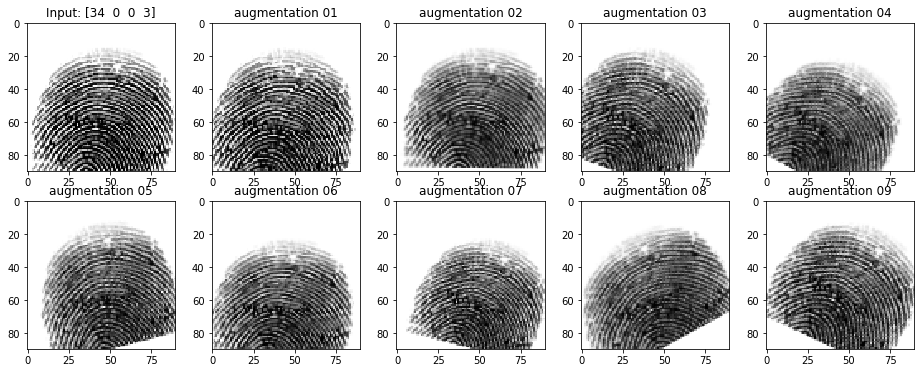

In [10]:
augs = []
for i in range (0,9):
    augs.append(Utils.dataAugmentationImg(random_img))

plt.figure(figsize=(16, 6))
plt.subplot(2, 5, 1)
plt.title('Input: %s' %random_label)
plt.imshow(random_img.squeeze(), cmap='gray')
for i, aug in enumerate (augs):
    plt.subplot(2, 5, i+2)
    plt.title('augmentation %02d' % int(i+1))
    plt.imshow(aug.squeeze(), cmap='gray')

# Train NN and store results

In [11]:
#Principales parámetros
nEpochs = 10
hard = 0

dataset_size = len(x_real)

In [12]:
#Combinamos las huellas alteradas
if hard:
    x_data = np.concatenate([x_easy, x_medium, x_hard], axis=0)
    y_data = np.concatenate([y_easy, y_medium, y_hard], axis=0)
else:
    x_data = np.concatenate([x_easy, x_medium], axis=0)
    y_data = np.concatenate([y_easy, y_medium], axis=0)

In [13]:
#Partimos los datos entre Entrenamiento y Test
x_train, x_val, label_train, label_val = train_test_split(x_data, y_data, test_size=0.1)

#Creamos el diccionario
labelPositionDictionary = {}

for i, y in enumerate(y_real):
    label = str(y)
    labelPositionDictionary[label] = i

In [14]:
#Generamos los datos de entrenamiento
train_gen = DataGenerator(x_train, label_train, x_real, labelPositionDictionary, shuffle=True)
val_gen = DataGenerator(x_val, label_val, x_real, labelPositionDictionary, shuffle=False)

In [ ]:
#Creamos el modelo
md = Utils.createModel('Model')

cb = TimingCallback()
cb.logs = []
#Entrenamos el modelo
history = md.fit(train_gen, epochs=nEpochs, validation_data=val_gen,callbacks=[cb])

Model: "Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 90, 90, 1)]  0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 90, 90, 1)]  0                                            
__________________________________________________________________________________________________
featureModel (Model)            (None, 22, 22, 32)   9568        input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
subtract_1 (Subtract)           (None, 22, 22, 32)   0           featureModel[1][0]           

In [ ]:
print('\n\nEl tiempo total de entrenamiento para esta red sobre un set de datos de '
      , dataset_size,' individuos ha sido de ',sum(cb.logs),' segundos')



In [ ]:
md.save('saved_model_30.h5')

# Hacemos un test positivo

In [ ]:
#Tomamos aleatoriamente una huella para probarla
random_idx = random.randint(0, len(x_val)-1)

#Obtenemos su imagen y su correspondiente etiqueta
random_img = x_val[random_idx]
random_label = label_val[random_idx]

#Para la imagen que hemos obtenido vamos a aplicar un desenfoque para simular la lectura de la misma
random_img = Utils.dataAugmentationImg(random_img)

# Vamos a obtener la imagen correspondiente a la etiqueta para obtener la huella con la que comparar.
match_key = str(random_label)

rx = x_real[labelPositionDictionary[match_key]].reshape((1, 90, 90, 1)).astype(np.float32) / 255.
ry = y_real[labelPositionDictionary[match_key]]

# Corremos el modelo sobre esta huella
pred_rx = md.predict([random_img, rx])

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('Input: %s' %random_label)
plt.imshow(random_img.squeeze(), cmap='gray')
plt.subplot(1, 2, 2)
plt.title('O: %.02f, %s' % (pred_rx, ry))
plt.imshow(rx.squeeze(), cmap='gray')

# Hacemos un test negativo

In [ ]:
# Ahora vamos a obtener una imagen distinta para realizar una comparación que debería de ser errónea
unmatch_key, unmatch_idx = random.choice(list(labelPositionDictionary.items()))

ux = x_real[unmatch_idx].reshape((1, 90, 90, 1)).astype(np.float32) / 255.
uy = y_real[unmatch_idx]

# Corremos el modelo sobre esta huella
pred_ux = md.predict([random_img, ux])

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('Input: %s' %random_label)
plt.imshow(random_img.squeeze(), cmap='gray')
plt.subplot(1, 2, 2)
plt.title('X: %.02f, %s' % (pred_ux, uy))
plt.imshow(ux.squeeze(), cmap='gray')

In [ ]:
treshold = 0.90
    
#Testamos el modelo
r, FRR, FAR = testModel(md,treshold,x_val,label_val,x_real
                        ,y_real,labelPositionDictionary,verb=0)


In [ ]:
print('El porcentaje de FRR es de: ',FRR/len(r))

In [ ]:
print('El porcentaje de FAR es de: ',FAR/len(r))

In [ ]:
print('El porcentaje de FRR es de: ',FRR/len(r))

In [ ]:
print('El porcentaje de FAR es de: ',FAR/len(r))